In [1]:
#For this program will be need tf-nightly
#install it with pip install -q tf-nightly
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tfa

In [2]:
print(tf.__version__)

2.4.0-dev20200713


In [3]:
import pathlib
dataset_url="https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir=tf.keras.utils.get_file(
    origin=dataset_url,
    fname='flower_photos',
    untar=True
)
data_dir=pathlib.Path(data_dir)

In [4]:
image_count=len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


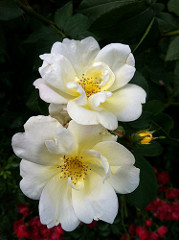

In [5]:
roses=list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

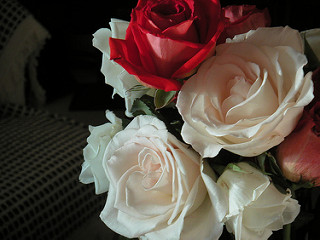

In [6]:
roses=list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

In [7]:
batch_size = 32
img_height = 180
img_width  = 180

In [12]:
train_ds=tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [11]:
val_ds=tf.keras.preprocessing.image_dataset_from_directory(

    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [13]:
class_names=train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


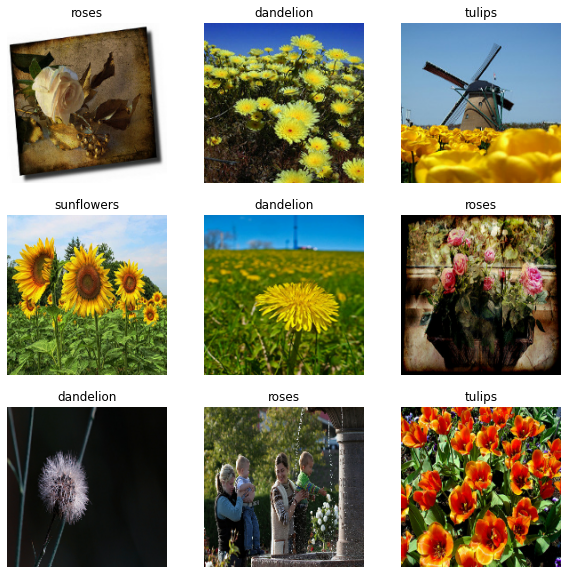

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [16]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [17]:
from tensorflow.keras  import layers
normalization_layer=tf.keras.layers.experimental.preprocessing.Rescaling(1./255)


In [18]:
normalized_ds=train_ds.map(lambda x,y : (normalization_layer(x),y))
image_batch,labels_batch = next(iter(normalized_ds))
first_image=image_batch[0]
print(np.min(first_image),np.max(first_image))

0.0 0.99638706


In [19]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [22]:
num_classes  = 5
model =  tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(32,3,activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3,activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(num_classes)
])

In [23]:
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [24]:
model.fit(train_ds,
batch_size=batch_size,
validation_data=val_ds,
epochs=3)

Epoch 1/3
92/92 [==============================] - 579s 6s/step - loss: 1.3772 - accuracy: 0.4271 - val_loss: 1.2023 - val_accuracy: 0.5504
Epoch 2/3
92/92 [==============================] - 207s 2s/step - loss: 1.0139 - accuracy: 0.6178 - val_loss: 1.0287 - val_accuracy: 0.5858
Epoch 3/3
92/92 [==============================] - 64s 692ms/step - loss: 0.7038 - accuracy: 0.7432 - val_loss: 1.0756 - val_accuracy: 0.5886


In [25]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))
list_ds = list_ds.shuffle(image_count,reshuffle_each_iteration=False)

In [26]:
for f in list_ds.take(5):
    print(f.numpy())

b'C:\\Users\\Zmix\\.keras\\datasets\\flower_photos\\daisy\\18679421522_3be9879e32.jpg'
b'C:\\Users\\Zmix\\.keras\\datasets\\flower_photos\\dandelion\\151385302_f8980a257f_n.jpg'
b'C:\\Users\\Zmix\\.keras\\datasets\\flower_photos\\daisy\\799964360_7e07a227ea_n.jpg'
b'C:\\Users\\Zmix\\.keras\\datasets\\flower_photos\\dandelion\\5598591979_ed9af1b3e9_n.jpg'
b'C:\\Users\\Zmix\\.keras\\datasets\\flower_photos\\roses\\15999816377_4b95e0b538_n.jpg'


In [27]:
class_names=np.array(sorted([item.name for item  in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [28]:
val_size=int(image_count*0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [30]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


In [31]:
def get_label(file_path):
    #convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    one_hot = parts[-2] == class_names
    return tf.argmax(one_hot)

def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    #resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
    label = get_label(file_path)
    #load the raw data from the file as string
    img = tf.io.read_file(file_path)
    img =decode_img(img)
    return img, label

In [32]:
#Set `num_parallel_calls`  so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [34]:
for image, label in train_ds.take(1):
    print("Image shape: ",image.numpy().shape)
    print("Label: ",label.numpy())

Image shape:  (180, 180, 3)
Label:  0


In [35]:
def configure_for_permofance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_permofance(train_ds)
val_ds = configure_for_permofance(val_ds)

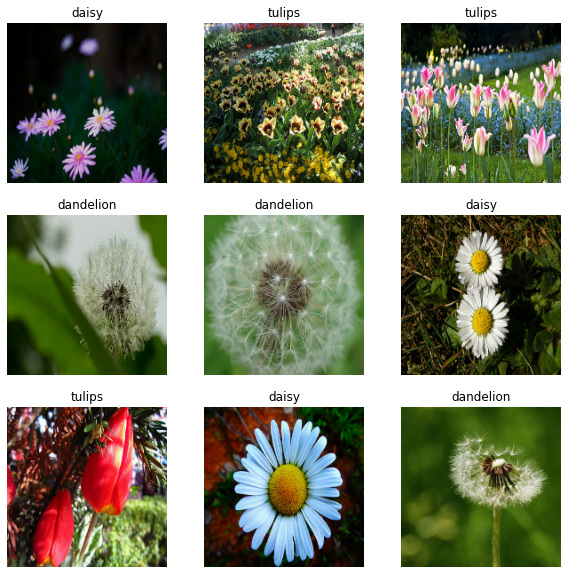

In [36]:
image_batch, labels_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = labels_batch[i]
    plt.title(class_names[label])
    plt.axis("off")

In [37]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3   
)

Epoch 1/3
92/92 [==============================] - 409s 4s/step - loss: 0.5502 - accuracy: 0.8120 - val_loss: 0.4271 - val_accuracy: 0.8529
Epoch 2/3
92/92 [==============================] - 486s 5s/step - loss: 0.2505 - accuracy: 0.9213 - val_loss: 0.2246 - val_accuracy: 0.9332
Epoch 3/3
92/92 [==============================] - 233s 3s/step - loss: 0.1039 - accuracy: 0.9751 - val_loss: 0.2293 - val_accuracy: 0.9319
